In [4922]:
import sys
# sys.path.insert(0, "./")
# sys.path.insert(0, "../../")
import torch
from torch.utils.data import Dataset
from utils_suboptimal import *
import random
import matplotlib.pyplot as plt

from torchvision.models import resnet50, resnet18
import argparse
import traceback
import seaborn as sns
import pandas as pd
import csv
import ast
import pdb

In [4923]:
GRID_SIZE =6
time_out = 600
K =8

In [4924]:

display_label ={
    "BLOCKING_ONLY_EXHAUSTIVE":"Exhaustive",
    "BLOCKING_ONLY_PRUNE_REDUCE": "Pruned-Reduce",
    "BLOCKING_ONLY_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "BLOCKING_ONLY_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "BLOCKING_ONLY_test":"Our approach",
    "ALL_MODS_EXHAUSTIVE":"Exhaustive",
    "ALL_MODS_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "ALL_MODS_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "ALL_MODS_test":"Our approach",
    "BOTH_UNIFORM_EXHAUSTIVE":"Exhaustive",
    "BOTH_UNIFORM_GREEDY_TRUE_WCD":"Greedy (true wcd)",
    "BOTH_UNIFORM_GREEDY_PRED_WCD":"Greedy (predicted wcd)",
    "BOTH_UNIFORM_test":"Our approach"
    
}
display_label_colors = {
    "BLOCKING_ONLY_EXHAUSTIVE": "#1b9e77",  # A greenish color
    "BLOCKING_ONLY_PRUNE_REDUCE": "#d95f02",  # An orangish color
    "BLOCKING_ONLY_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "BLOCKING_ONLY_GREEDY_PRED_WCD": "#e7298a",  # A crimson-like pink color
    "BLOCKING_ONLY_test": "#66a61e",  # A grass green color
    "ALL_MODS_EXHAUSTIVE": "#1b9e77",  # A golden color
    "ALL_MODS_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "ALL_MODS_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "ALL_MODS_test": "#66a61e",  # A grass green color
    "BOTH_UNIFORM_EXHAUSTIVE": "#1b9e77",  # A golden color
    "BOTH_UNIFORM_GREEDY_PRED_WCD": "#e7298a",   # A crimson-like pink color
    "BOTH_UNIFORM_GREEDY_TRUE_WCD": "#7570b3",  # A bluish color
    "BOTH_UNIFORM_test": "#66a61e"  # A grass green color
}


In [4925]:
experiment_label ="BLOCKING_ONLY_EXHAUSTIVE" 
cost = 0
base_data_dir = "./baselines/data" #"./data"


def extract_labels(folder_path, grid_size = 6):
     # List to hold folder names
    folder_names = []

    # Iterate over all entries in the given folder
    for entry in os.listdir(folder_path):
        # Check if it's a directory
        full_path = os.path.join(folder_path, entry)
        if os.path.isdir(full_path):
            # Add the folder name to the list
            if entry in display_label.keys():
                folder_names.append(entry)

    return folder_names

In [4926]:
def read_env_data(file_name):
    with open(file_name, "rb") as f:
        loaded_dataset = pickle.load(f)
        x_data = []
        y_data = []
        for i in range(loaded_dataset. __len__()):

            x_data.append(loaded_dataset[i][0].unsqueeze(0))
            y_data.append(loaded_dataset[i][1].unsqueeze(0))

        x_init_data = torch.cat(x_data).numpy()
        y_init_data = torch.cat(y_data).numpy()
        
    return x_init_data, y_init_data

def read_csv(filename):
    """
    Reads numbers from a CSV file and returns them as a list of lists.

    Args:
    filename (str): The name of the CSV file.

    Returns:
    list of lists: Each sublist contains numbers from a row in the CSV file.
    """
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert each string in the row to an integer
            number_row = [ast.literal_eval(item) for item in row]
            data.append(number_row)
    return data 
def display_init_final(x_init,y_init,x_final,y_final, start_from_idx =0, display_interval = 10):
    for idx in range(0,x_init.shape[0],display_interval):
        print(idx)
        x_i = x_init[idx]


        print("Init true WCD = ",y_init[idx])
        plot_grid(decode_grid_design(x_i,return_map= True).tolist())

        x_k = x_final[idx]

        print("Final WCD = ",y_final[idx])
        plot_grid(decode_grid_design(x_k,return_map= True).tolist())

        print("\n =========================")

In [4927]:
def sort_with_correspondence(arr_to_sort, arr_to_rearrange):
    """
    Sorts each row of 'arr_to_sort' and rearranges each corresponding row of 'arr_to_rearrange' to match.

    Parameters:
    arr_to_sort (np.array): The array whose rows are to be sorted.
    arr_to_rearrange (np.array): The array whose rows are to be rearranged to match the sorting of 'arr_to_sort'.

    Returns:
    (np.array, np.array): A tuple containing the sorted 'arr_to_sort' and the correspondingly rearranged 'arr_to_rearrange'.
    """
    sorted_arr = np.empty_like(arr_to_sort)
    rearranged_arr = np.empty_like(arr_to_rearrange)

    for i in range(arr_to_sort.shape[0]):
        # Get the indices that would sort the current row
        sorted_indices = np.argsort(arr_to_sort[i])

        # Sort the current row in 'arr_to_sort' and rearrange the corresponding row in 'arr_to_rearrange'
        sorted_arr[i] = arr_to_sort[i][sorted_indices]
        rearranged_arr[i] = arr_to_rearrange[i][sorted_indices]

    return sorted_arr, rearranged_arr

    
from scipy.interpolate import make_interp_spline
from scipy.ndimage import uniform_filter1d
def moving_average(data, window_size):
    return uniform_filter1d(data, size=window_size, mode='reflect')

def plot_summary(df, ylabel, title, show_std_err=True, filename=None, use_given_budget=True, smoothing_window=4, 
                 use_log_scale=False, show_title=False):
    
    selections = None
    lw = 4
    font_size = 70
    fig_size = (20, 16)
    
    # Check if "time" is in ylabel
    if "Time" in ylabel:
        # Create two separate plots
        fig, ax = plt.subplots(figsize=fig_size, dpi=300, constrained_layout=True)

        for label, row in df.iterrows():
            print(label)
            print(row['given_budget'].shape,row['mean'].shape)
            data = pd.DataFrame({
                'budget': row['given_budget'] if use_given_budget else row['realized_budget'],
                'mean': row['mean']
            })
            
            # Plot other curves on the second plot
            legend_label = f"{display_label[label]}(n={row['n']})"
            legend_label = f"{display_label[label]}"

            # Group by 'budget' and calculate timeout statistics
            timeout_data = data.groupby('budget')['mean'].agg(['count', lambda x: (x >= time_out).sum()]).reset_index()
            timeout_data.columns = ['budget', 'total_count', 'count_timeout']
            
            # Calculate percentage timeout for each budget
            timeout_data['percentage_timeout'] = (timeout_data['count_timeout'] / timeout_data['total_count']) * 100
            
            timeout_data = timeout_data[timeout_data["budget"] < 20]
            print(timeout_data)

            # Group by 'budget' and calculate standard error of the mean
            grouped_data = data.groupby('budget')['mean'].agg(['mean', 'sem', "count"]).reset_index()
            print(grouped_data)

            # Apply log scale if specified
            if use_log_scale:
                grouped_data['sem'] = grouped_data['sem'] / grouped_data['mean']
                grouped_data["mean"] = np.log10(grouped_data["mean"])

            # Filter out data points with budget greater than 20 and count less than 1
            grouped_data = grouped_data[grouped_data["budget"] < 20]
            grouped_data = grouped_data[grouped_data["count"] > 1]

            # Apply smoothing if specified
            if smoothing_window:
                grouped_data['mean'] = moving_average(grouped_data['mean'], smoothing_window)

            
            ax.errorbar(grouped_data['budget'], grouped_data['mean'], yerr=grouped_data['sem'], linewidth=lw,fmt='-o',
                             capsize=1, label=legend_label, color=display_label_colors[label])
            if show_std_err:
                ax.fill_between(grouped_data["budget"], grouped_data['mean'] - grouped_data['sem'],
                                      grouped_data['mean'] + grouped_data['sem'], alpha=0.2,
                                      color=display_label_colors[label])

            # Set common xlabel, legend, and title for both plots
            ax.set_ylabel(ylabel,fontsize = font_size)
            ax.set_xlabel("budget",fontsize = font_size)
            plt.yticks(np.arange(-2, 2.5, 1),fontsize = font_size)
            plt.xticks(range(0,35,5),fontsize = font_size)
            ax.tick_params(axis='both', which='major', length=font_size/2)
            ax.legend(fontsize = font_size)
            if show_title:
                ax.set_title(title)
    else:
        # Create a single plot
        fig, ax = plt.subplots(figsize=fig_size, dpi=300, constrained_layout=True)

        for label, row in df.iterrows():
            print(label)
            legend_label = f"{display_label[label]}(n={row['n']})"
            data = pd.DataFrame({
                'budget': row['given_budget'] if use_given_budget else row['realized_budget'],
                'mean': row['mean']
            })

            # Group by 'budget' and calculate standard error of the mean
            grouped_data = data.groupby('budget')['mean'].agg(['mean', 'sem',"std", "count"]).reset_index()
            print(grouped_data)

            # Apply log scale if specified
            if use_log_scale:
                grouped_data['sem'] = grouped_data['sem'] / grouped_data['mean']
                grouped_data["mean"] = np.log10(grouped_data["mean"])

            # Filter out data points with budget greater than 20 and count less than 1
            grouped_data = grouped_data[grouped_data["budget"] < 40]
            grouped_data = grouped_data[grouped_data["budget"]%2 ==1]

            grouped_data = grouped_data[grouped_data["count"] > 1]

            # Apply smoothing if specified
            if smoothing_window:
                grouped_data['mean'] = moving_average(grouped_data['mean'], smoothing_window)

            # Plot other curves on the single plot
            legend_label = f"{display_label[label]}(n={row['n']})"
            legend_label = f"{display_label[label]}"
            ax.errorbar(grouped_data['budget'], grouped_data['mean'], yerr=grouped_data['sem'], fmt='-o',
                        capsize=1, label=legend_label, color=display_label_colors[label], linewidth = lw)
            if show_std_err:
                ax.fill_between(grouped_data["budget"], grouped_data['mean'] - grouped_data['sem'],
                                 grouped_data['mean'] + grouped_data['sem'], alpha=0.2,
                                 color=display_label_colors[label])
            if "test" in label:
                label = f"{label}_{str(N_LAMBDA).zfill(3)}"
            grouped_data.to_csv(f"plot_data/{label}.csv")

        # Set xlabel, legend, and title for single plot
        ax.set_xlabel("budget",fontsize = font_size)
        ax.set_ylabel(ylabel,fontsize = font_size)
        plt.yticks(np.arange(1.5, 4, 0.5),fontsize = font_size)
        plt.xticks(range(0,21,5),fontsize = font_size)
        ax.tick_params(axis='both', which='major', length=font_size/2)
        # ax.set_ylim(0.50)
        ax.legend(fontsize = font_size)
        if show_title:
            ax.set_title(title)
        
    # Save and show plot(s)
    plt.tight_layout()
    
    if filename:
        plt.savefig(f"./plots/{filename}", dpi=500, bbox_inches='tight')
    plt.show()


In [4928]:
# Initialize DataFrames to store summary data
columns = ["Experiment Label","n",'mean', 'std_err',"given_budget", "realized_budget"]
time_summary = pd.DataFrame(columns=columns)
wcd_summary = pd.DataFrame(columns=columns)
percent_completed_summary = pd.DataFrame(columns=columns)
percent_reduced_summary = pd.DataFrame(columns=columns)

In [4929]:
results_df = pd.DataFrame(columns=["Experiment Label","Grid Size","n","Mean Time (sd)", "Mean Time (s)",  "% Completed", "% Reduced", "Mean WCD Reduction (sd)","Mean WCD Reduction"])
experiment_labels = extract_labels(f"./data/grid{GRID_SIZE}/K{8}", 
                                   grid_size = GRID_SIZE )+ extract_labels(f"./baselines/data/grid{GRID_SIZE}/K{8}/timeout_{time_out}",
                                                                                                      grid_size = GRID_SIZE)
experiment_labels = sorted(experiment_labels,reverse=False)

In [4930]:
experiment_labels=[
    'BOTH_UNIFORM_GREEDY_PRED_WCD',
 'BOTH_UNIFORM_GREEDY_TRUE_WCD',
 'BOTH_UNIFORM_test']

In [4931]:
select_idx_blocking_only = 166
select_idx_all_mods = 309 #150
select_idx_both_uniform = 2200 #300

USE_COMPLETED_ONLY = True
ratio = "ratio_1_3"
N_LAMBDA = 17*17

In [4932]:
if  GRID_SIZE == 10:#and USE_COMPLETED_ONLY:
    # Assuming experiment_labels is a list containing your labels
    # Use list comprehension to filter out labels containing "EXHAUSTIVE"
    experiment_labels = [label for label in experiment_labels if "ALL_MODS" not in label] #or "BLOCKING_ONLY" in label

In [4933]:
selections_blocking_only = [True]*select_idx_blocking_only
selections_both_uniform = [True]*select_idx_both_uniform
selections_all_mods = [True]*select_idx_all_mods
for experiment_label in experiment_labels:
    if "ALL_MODS_GREEDY_PRED" in experiment_label: continue
    if experiment_label in ["BLOCKING_ONLY_test","ALL_MODS_test","BOTH_UNIFORM_test"]:
        base_data_dir = f"./data/grid{GRID_SIZE}/K{K}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/n_lambdas_{N_LAMBDA}"
        elif experiment_label == "BLOCKING_ONLY_test":
            base_data_dir = f"{base_data_dir}/n_lambdas_{N_LAMBDA}"
        else:
            base_data_dir = f"{base_data_dir}/n_lambdas_{int(np.sqrt(N_LAMBDA))}"
        
            
    else:
        base_data_dir = f"./baselines/data/grid{GRID_SIZE}/K{K}/timeout_{time_out}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
    
    
    if "BLOCKING_ONLY" in experiment_label:
        select_idx = len(selections_blocking_only)
    elif "BOTH_UNIFORM" in experiment_label:
        select_idx = len(selections_both_uniform)
    else:
        select_idx = len(selections_all_mods)
        
    times = np.array(read_csv(f'{base_data_dir}/times_{GRID_SIZE}_{experiment_label}.csv'))
    print(experiment_label, "Before:",times.shape)
    times=times[0:select_idx]
    print(times.shape)
    # # Store in DataFrames
    # if experiment_label in ["ALL_MODS_test","BLOCKING_ONLY_test", "BOTH_UNIFORM_test"]:
    #     continue
    # else:
    if "BLOCKING_ONLY" in experiment_label:
        selections_blocking_only  = np.logical_and(selections_blocking_only, (times<time_out).all(axis = 1))
        # print((times<time_out).any(axis = 1))
    elif "BOTH_UNIFORM" in experiment_label:
        selections_both_uniform  = np.logical_and(selections_both_uniform, (times<time_out).all(axis = 1))
    else:
        print(experiment_label)
        selections_all_mods  = np.logical_and(selections_all_mods, (times<time_out).all(axis = 1))
        

BOTH_UNIFORM_GREEDY_PRED_WCD Before: (2200, 19)
(2200, 19)
BOTH_UNIFORM_GREEDY_TRUE_WCD Before: (2200, 19)
(2200, 19)
BOTH_UNIFORM_test Before: (2200, 10)
(2200, 10)


In [4934]:
if not USE_COMPLETED_ONLY: # use all without filtering timed out
    selections_blocking_only = np.array([True]*select_idx_blocking_only)
    selections_both_uniform = np.array([True]*select_idx_both_uniform)
    selections_all_mods = np.array([True]*select_idx_all_mods)

In [4935]:
final_wcds ={}
for experiment_label in experiment_labels:
    if "ALL_MODS_GREEDY_PRED" in experiment_label: continue
    if experiment_label in ["BLOCKING_ONLY_test","ALL_MODS_test","BOTH_UNIFORM_test"]:
        base_data_dir = f"./data/grid{GRID_SIZE}/K{K}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/n_lambdas_{N_LAMBDA}"
        elif experiment_label == "BLOCKING_ONLY_test":
            base_data_dir = f"{base_data_dir}/n_lambdas_{N_LAMBDA}"
        else:
            base_data_dir = f"{base_data_dir}/n_lambdas_{int(np.sqrt(N_LAMBDA))}"
        
    else:
        base_data_dir = f"./baselines/data/grid{GRID_SIZE}/K{8}/timeout_{time_out}/{experiment_label}" #"./data"
        if "ALL_MODS" in experiment_label:
            base_data_dir = f"{base_data_dir}/{ratio}/"
    

    times = read_csv(f'{base_data_dir}/times_{GRID_SIZE}_{experiment_label}.csv')
    budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
    wcd_change = read_csv(f'{base_data_dir}/wcd_change_{GRID_SIZE}_{experiment_label}.csv')

    budget = np.array(budgets).flatten()
    time_raw = np.array(times)
    times = np.array(times)

    wcd_change = np.array(wcd_change)

    budget = np.array(budgets).flatten()
    times = np.array(times)
    wcd_change = np.array(wcd_change)
        
    if "BLOCKING_ONLY" in experiment_label:
        selections  = selections_blocking_only
        select_idx = selections_blocking_only.shape[0]
    elif "BOTH_UNIFORM" in experiment_label:
        selections  = selections_both_uniform
        select_idx = selections_both_uniform.shape[0]
    else:
        selections  = selections_all_mods
        select_idx = selections_all_mods.shape[0]

    # Store in DataFrames
    if experiment_label in ["ALL_MODS_test","BLOCKING_ONLY_test", "BOTH_UNIFORM_test"]:
        # if experiment_label== "ALL_MODS_test": continue
        print(experiment_label)
        budgets = read_csv(f'{base_data_dir}/budgets_{GRID_SIZE}_{experiment_label}.csv')
        budgets = np.array(budgets)
        max_budgets = np.array(read_csv(f'{base_data_dir}/max_budgets_{GRID_SIZE}_{experiment_label}.csv'))[0]
        
        wcd_change = np.array(wcd_change)[0:select_idx][selections]
        times = times[0:select_idx][selections]
        budgets = budgets[0:select_idx][selections]
        flattened_times = times.flatten()
        flattened_wcd_changes = wcd_change.flatten()
        flattened_realized_budgets = budgets.flatten()
        flattened_given_budgets =np.tile(max_budgets, times.shape[0])
        n = times.shape[0]
        final_wcds[experiment_label] = wcd_change[:,-1]
        print("There are ",np.sum(np.array(flattened_given_budgets)==1), "Ones",budgets.shape[0])
        time_summary.loc[experiment_label] = [experiment_label,n,flattened_times, flattened_times,flattened_given_budgets, flattened_realized_budgets]
        wcd_summary.loc[experiment_label] = [experiment_label,n,flattened_wcd_changes, flattened_wcd_changes,flattened_given_budgets, flattened_realized_budgets]
    else:
        print(experiment_label)

        wcd_change= wcd_change[0:select_idx][selections]# only envs that completed
        n = times.shape[0]
        #ONLY those that completed
        realized_budgets = np.array(read_csv(f'{base_data_dir}/num_changes_{GRID_SIZE}_{experiment_label}.csv')).sum(axis =2)[0:select_idx][selections]
        
        given_budget = np.array(read_csv(f'{base_data_dir}/max_budgets_{GRID_SIZE}_{experiment_label}.csv')*n)[0:select_idx][selections]
        
        if "BOTH_UNIFORM" in experiment_label or "BLOCKING" in experiment_label:
            given_budget = given_budget+1 # minor fix for budget misalignment
        
        print(given_budget.shape)
        times= times[0:select_idx][selections]
        
        n = times.shape[0]
        final_wcds[experiment_label] = wcd_change[:,-1]
        time_summary.loc[experiment_label] = [experiment_label,n,times.flatten(), times.flatten(),given_budget.flatten(),realized_budgets.flatten()]
        wcd_summary.loc[experiment_label] = [experiment_label,n,wcd_change.flatten(), wcd_change.flatten(),given_budget.flatten(),realized_budgets.flatten()]

BOTH_UNIFORM_GREEDY_PRED_WCD
(1373, 19)
BOTH_UNIFORM_GREEDY_TRUE_WCD
(1373, 19)
BOTH_UNIFORM_test
There are  1373 Ones 1373


In [4936]:
time_summary_uniform_df = time_summary[time_summary['Experiment Label'].str.contains("UNIFORM")]
wcd_summary_uniform_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("UNIFORM")]

# Splitting the DataFrame based on experiment labels
time_summary_blocking_df = time_summary[time_summary['Experiment Label'].str.contains("BLOCKING")]
wcd_summary_blocking_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("BLOCKING")]

time_summary_all_mods_df = time_summary[time_summary['Experiment Label'].str.contains("ALL_MODS")]
wcd_summary_all_mods_df = wcd_summary[wcd_summary['Experiment Label'].str.contains("ALL_MODS")]

In [4937]:
time_summary_uniform_df

,Experiment Label,n,mean,std_err,given_budget,realized_budget
BOTH_UNIFORM_GREEDY_PRED_WCD,BOTH_UNIFORM_GREEDY_PRED_WCD,1373,"[0.11708378791809082, 0.11708378791809082, 0.1...","[0.11708378791809082, 0.11708378791809082, 0.1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
BOTH_UNIFORM_GREEDY_TRUE_WCD,BOTH_UNIFORM_GREEDY_TRUE_WCD,1373,"[64.56798505783081, 64.56798505783081, 64.5679...","[64.56798505783081, 64.56798505783081, 64.5679...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
BOTH_UNIFORM_test,BOTH_UNIFORM_test,1373,"[0.0, 0.0, 0.19768200383911133, 0.197682003839...","[0.0, 0.0, 0.19768200383911133, 0.197682003839...","[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 1, 3, 5, 7...","[0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [4938]:
use_given_budget = True
smoothing_window=2
show_title = False
file_type = "pdf"


BOTH_UNIFORM_GREEDY_PRED_WCD
(26087,) (26087,)
    budget  total_count  count_timeout  percentage_timeout
0        1         1373              0                 0.0
1        2         1373              0                 0.0
2        3         1373              0                 0.0
3        4         1373              0                 0.0
4        5         1373              0                 0.0
5        6         1373              0                 0.0
6        7         1373              0                 0.0
7        8         1373              0                 0.0
8        9         1373              0                 0.0
9       10         1373              0                 0.0
10      11         1373              0                 0.0
11      12         1373              0                 0.0
12      13         1373              0                 0.0
13      14         1373              0                 0.0
14      15         1373              0                 0.0
15      1

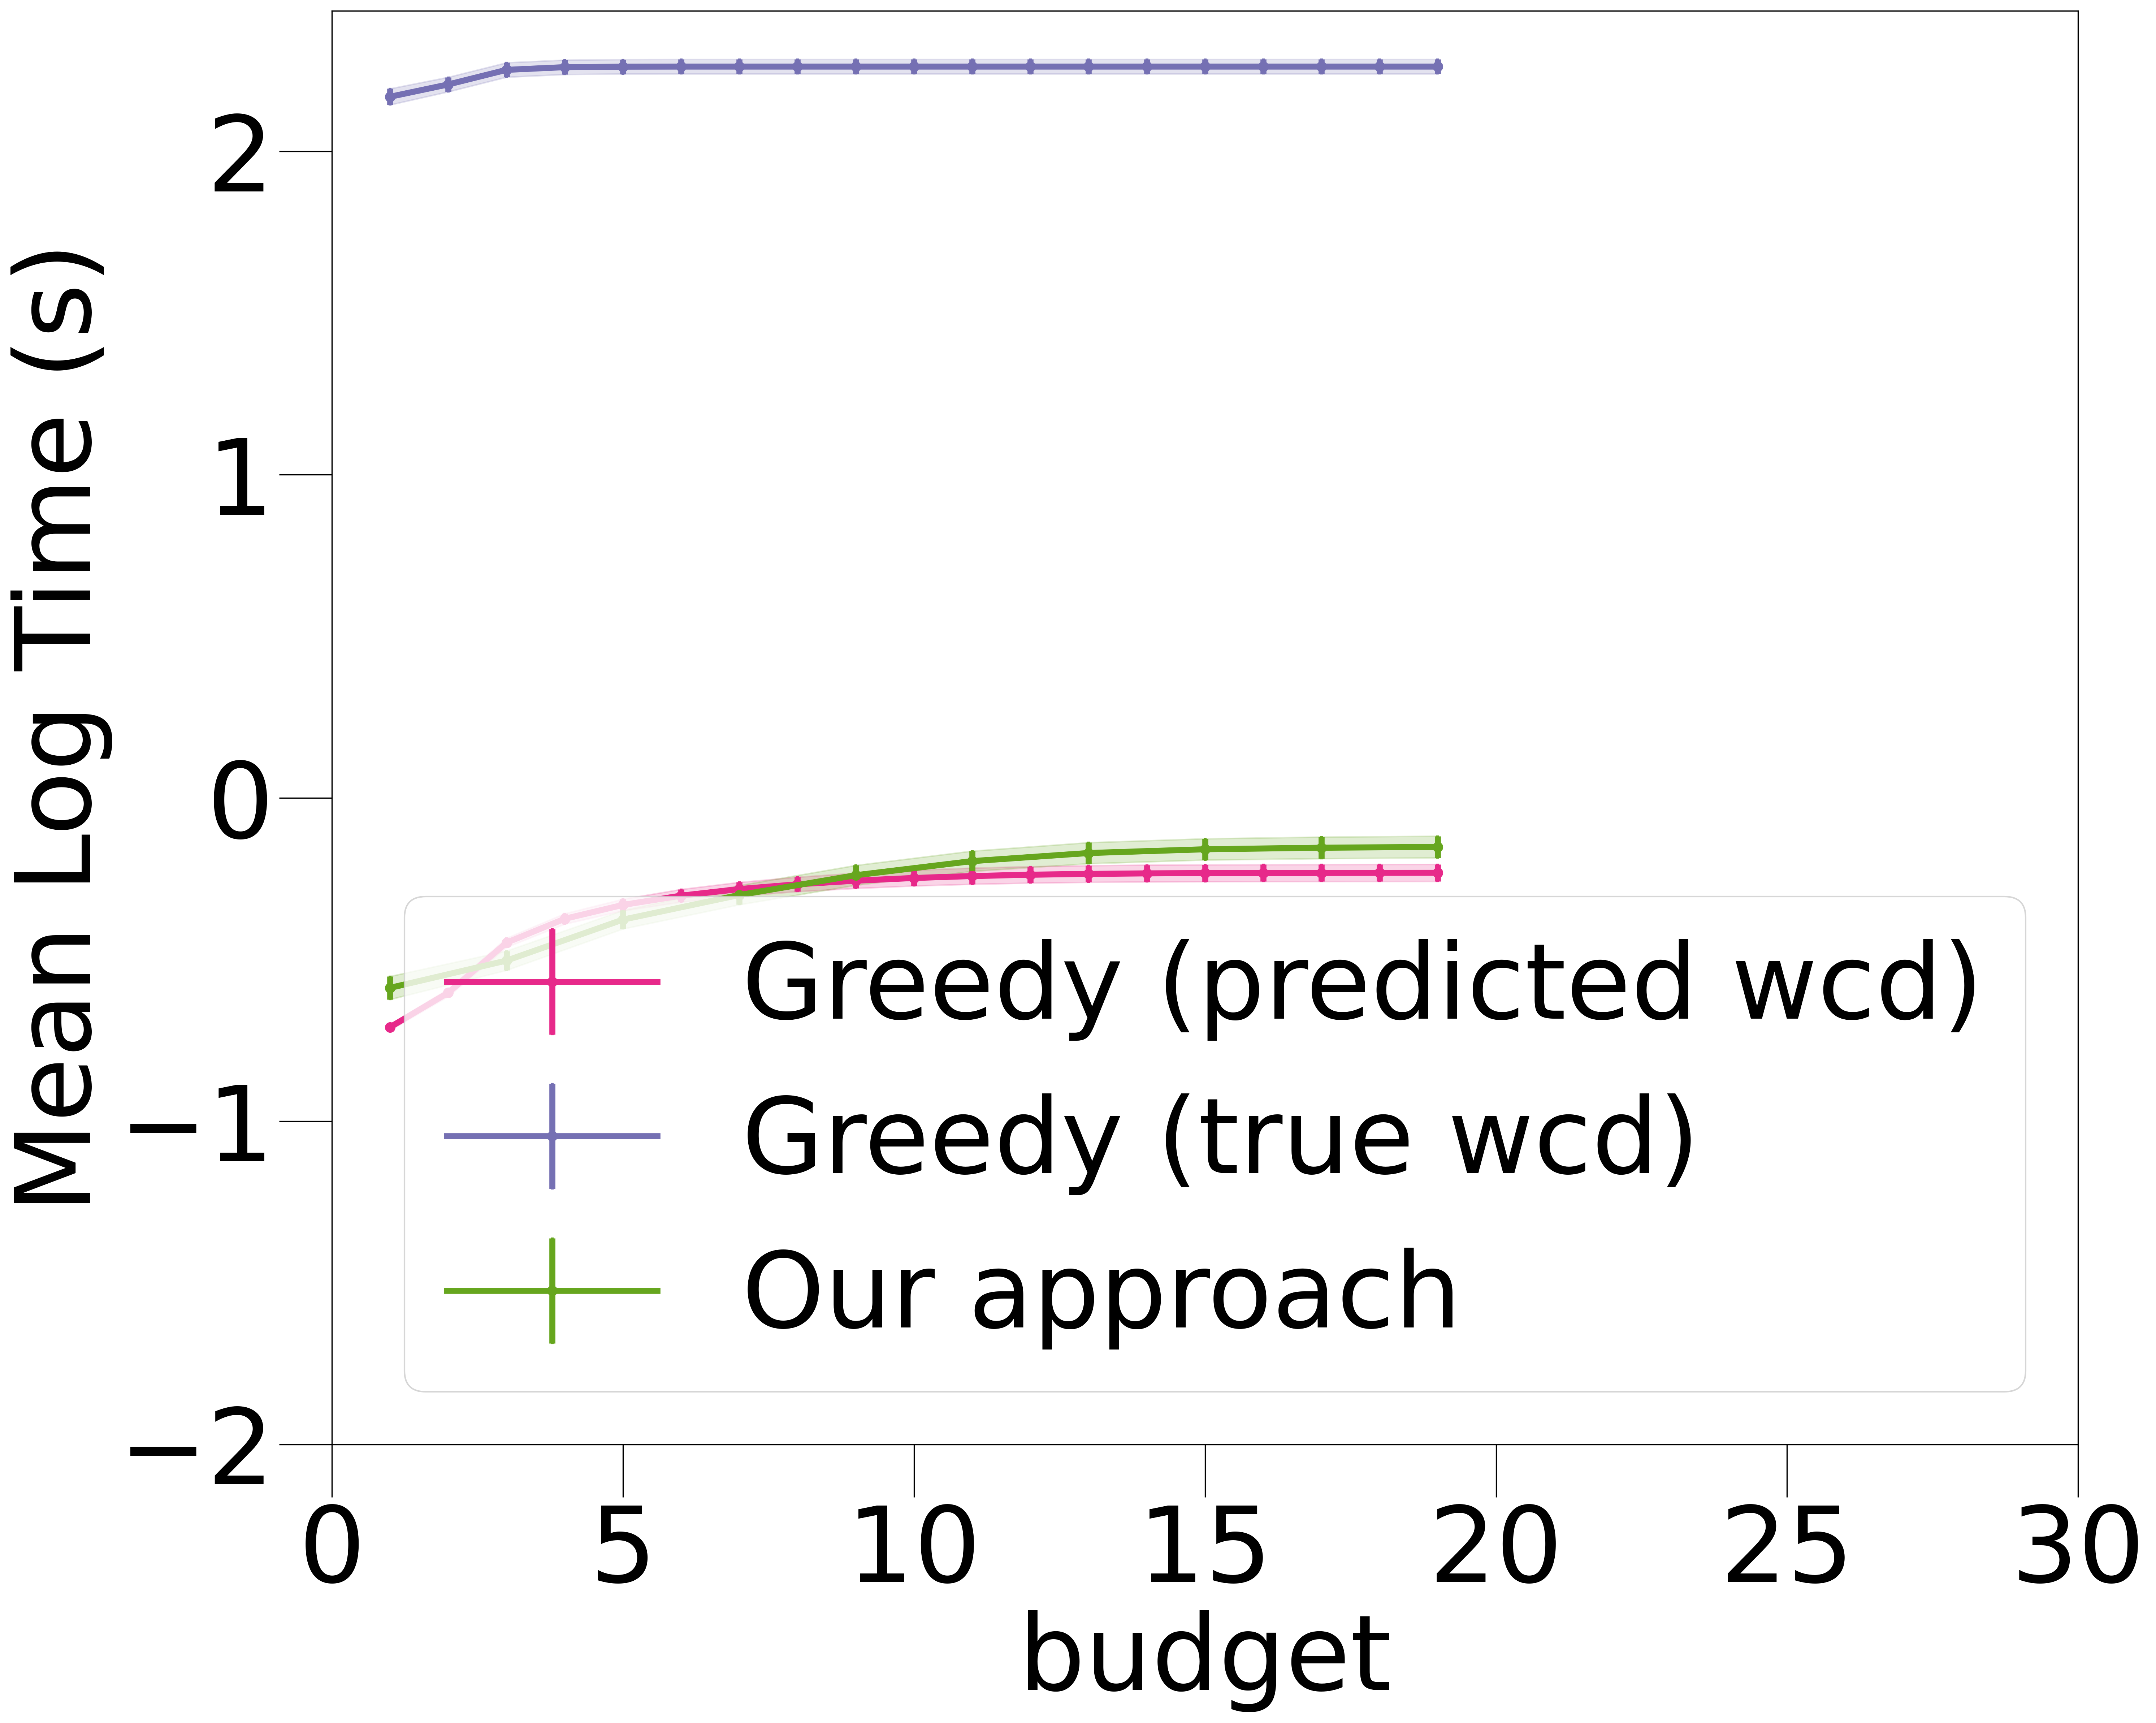

BOTH_UNIFORM_GREEDY_PRED_WCD
    budget      mean       sem       std  count
0        1  2.083030  0.056383  2.089215   1373
1        2  2.541879  0.060902  2.256646   1373
2        3  2.721049  0.063968  2.370273   1373
3        4  2.788055  0.065725  2.435363   1373
4        5  2.808449  0.066373  2.459382   1373
5        6  2.812819  0.066797  2.475079   1373
6        7  2.835397  0.067137  2.487696   1373
7        8  2.838310  0.067324  2.494616   1373
8        9  2.836854  0.067706  2.508797   1373
9       10  2.834669  0.067824  2.513153   1373
10      11  2.841952  0.067829  2.513332   1373
11      12  2.843409  0.067847  2.514003   1373
12      13  2.848507  0.067538  2.502548   1373
13      14  2.849235  0.067535  2.502447   1373
14      15  2.849235  0.067535  2.502447   1373
15      16  2.849235  0.067535  2.502447   1373
16      17  2.849235  0.067535  2.502447   1373
17      18  2.849235  0.067535  2.502447   1373
18      19  2.849235  0.067535  2.502447   1373
BOTH_UNIFOR

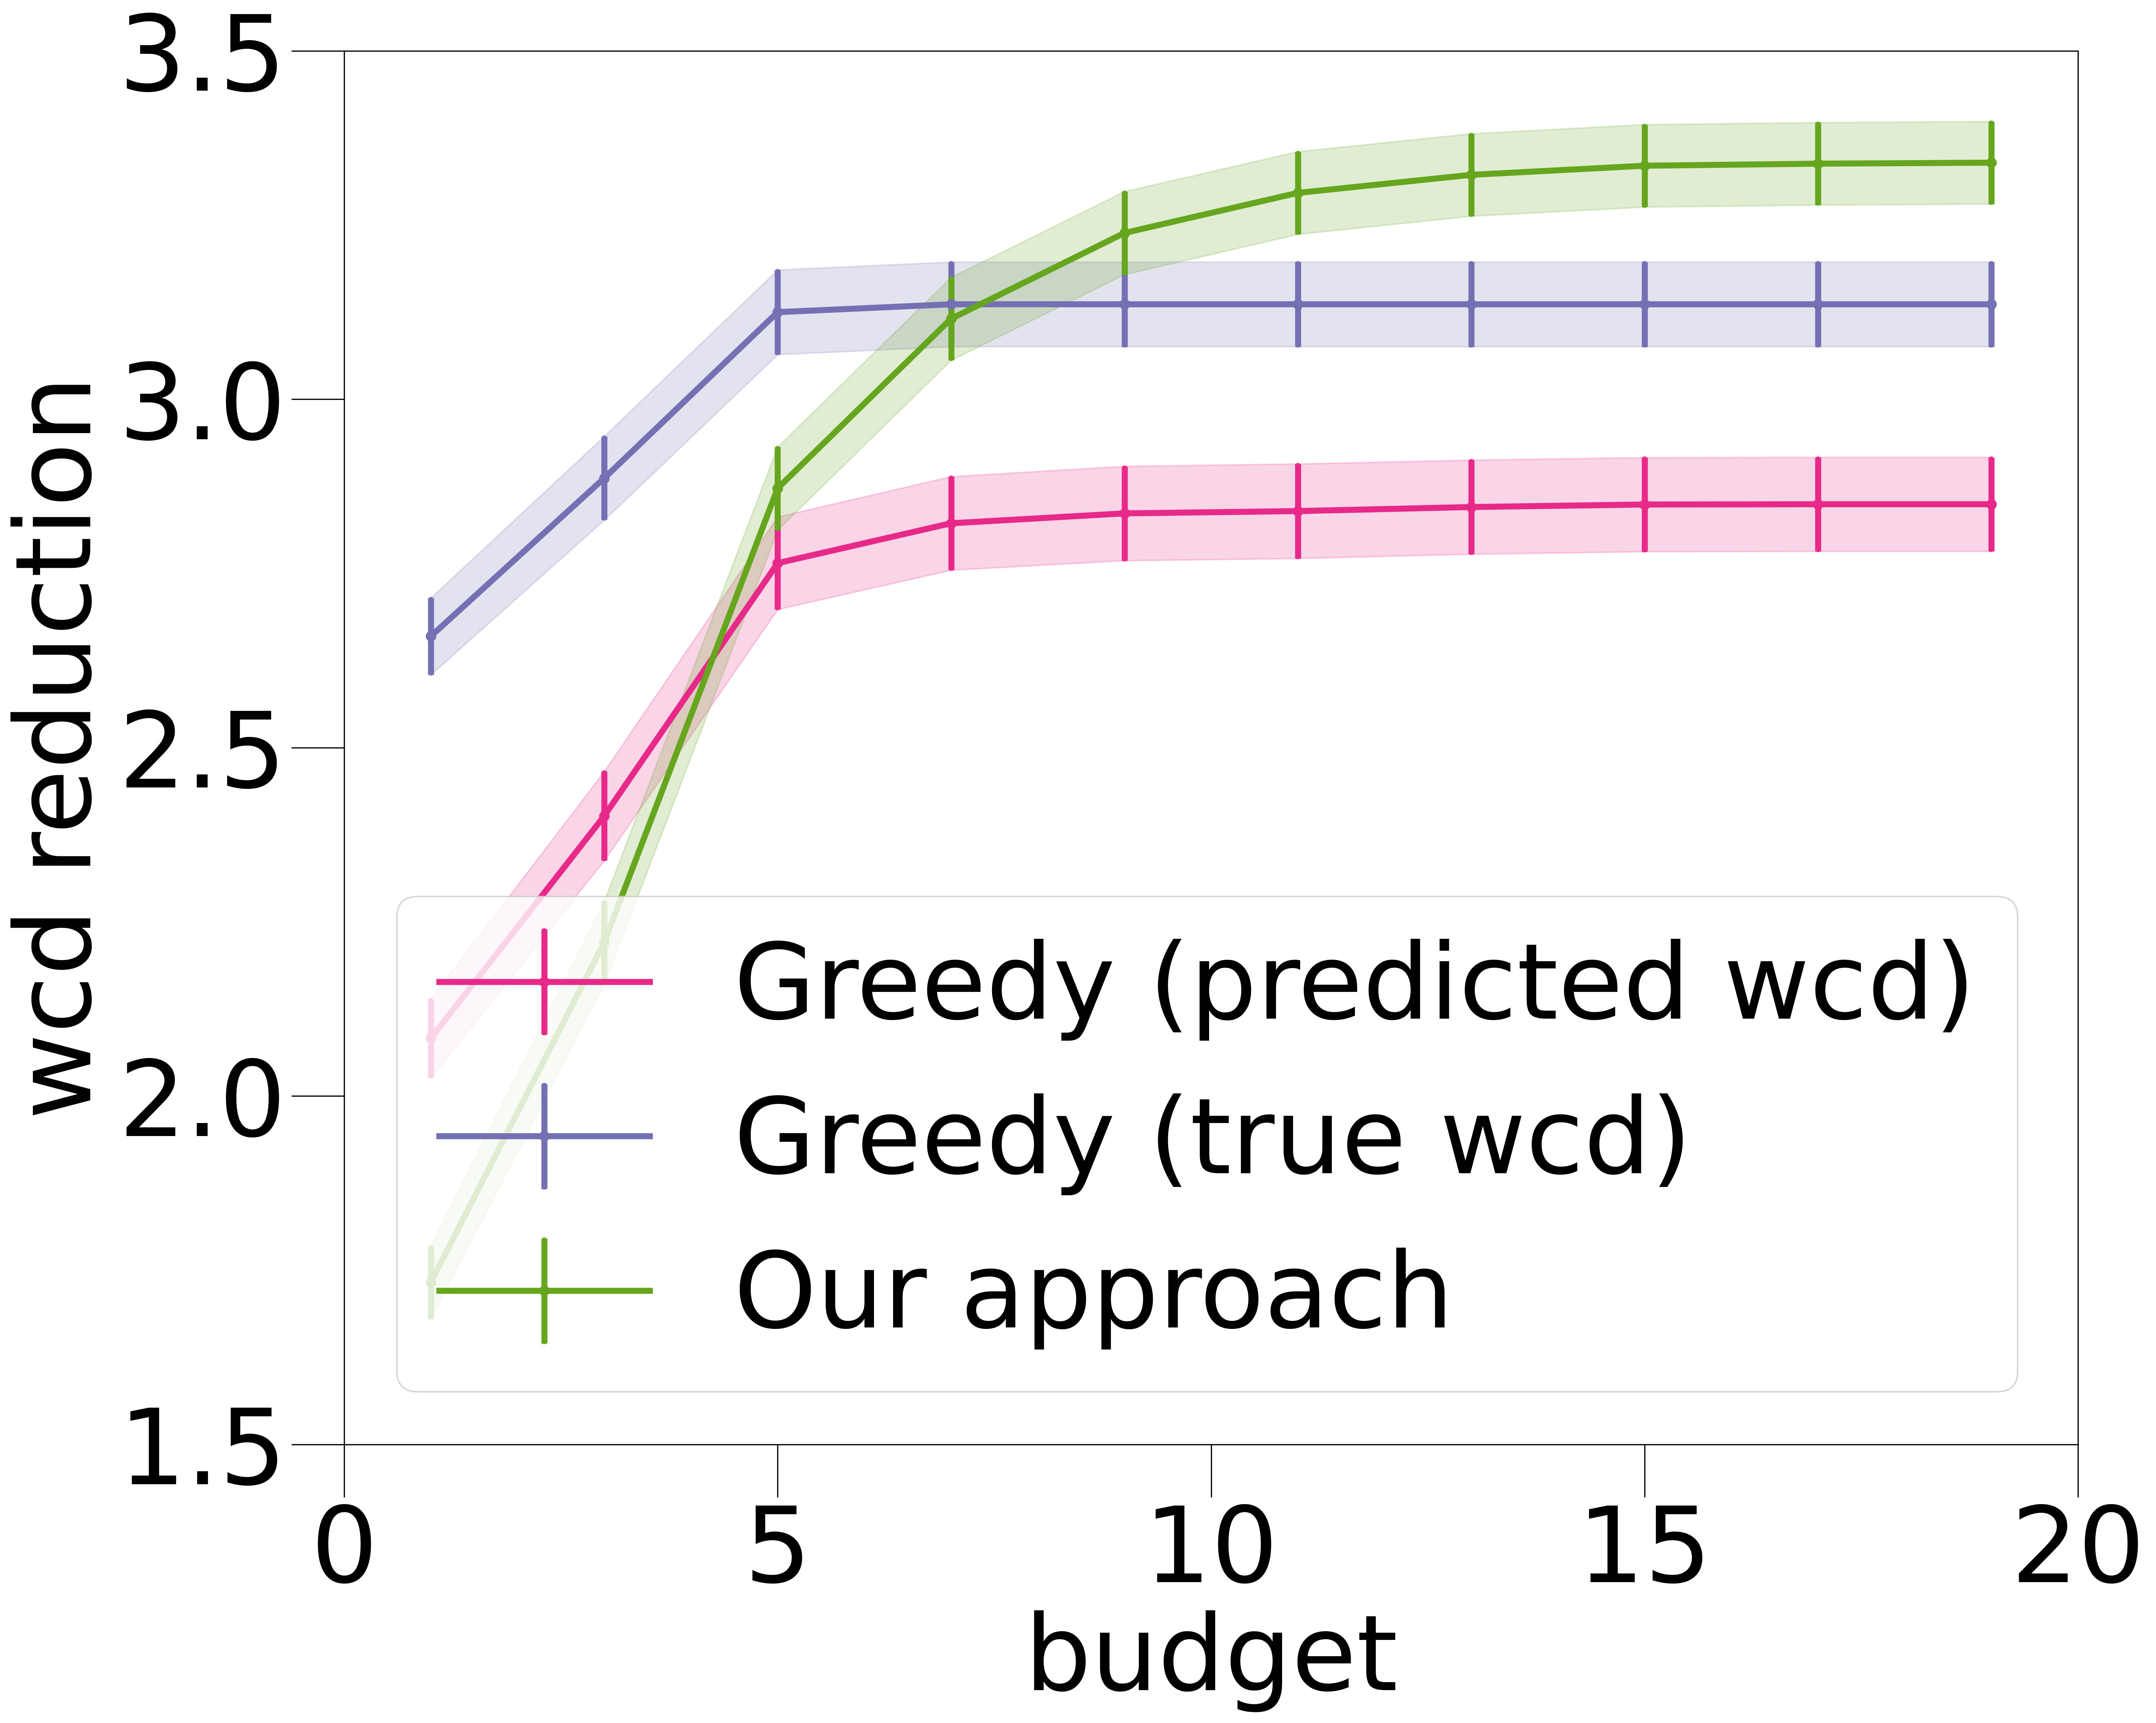

In [4939]:
plot_summary(time_summary_uniform_df, 'Mean Log Time (s)', f'Uniform Modifications',
             use_given_budget = use_given_budget,show_std_err= True,show_title=show_title,
            filename =f"time/k{K}_time_uniform_cost.{file_type}",use_log_scale = True,smoothing_window=smoothing_window)

# Plotting WCD Change
plot_summary(wcd_summary_uniform_df, 'wcd reduction', f'Uniform Modifications',
             use_given_budget = use_given_budget, show_title=show_title,
            filename =f"wcd_reduction/k{K}_wcd_reduction_uniform_cost.{file_type}",smoothing_window=smoothing_window)

In [4940]:
results_summary = wcd_summary["mean"].to_dict()
results_summary
from scipy.stats import ttest_ind, mannwhitneyu

# Given data
wcd_summery = final_wcds

# Extract the arrays
pred_wcd = wcd_summery['BOTH_UNIFORM_GREEDY_PRED_WCD']
true_wcd = wcd_summery['BOTH_UNIFORM_GREEDY_TRUE_WCD']
test_wcd = wcd_summery['BOTH_UNIFORM_test']

# Perform independent t-tests
t_test_pred_true = ttest_ind(pred_wcd, true_wcd)
t_test_pred_test = ttest_ind(pred_wcd, test_wcd)
t_test_true_test = ttest_ind(true_wcd, test_wcd)

# Perform Mann-Whitney U tests
mannwhitney_pred_true = mannwhitneyu(pred_wcd, true_wcd)
mannwhitney_pred_test = mannwhitneyu(pred_wcd, test_wcd)
mannwhitney_true_test = mannwhitneyu(true_wcd, test_wcd)

# Report the p-values
print("T-test p-values:")
print(f"Pred WCD vs. True WCD: {t_test_pred_true.pvalue}")
print(f"Pred WCD vs. Test WCD: {t_test_pred_test.pvalue}")
print(f"True WCD vs. Test WCD: {t_test_true_test.pvalue}")

print("\nMann-Whitney U test p-values:")
print(f"Pred WCD vs. True WCD: {mannwhitney_pred_true.pvalue}")
print(f"Pred WCD vs. Test WCD: {mannwhitney_pred_test.pvalue}")
print(f"True WCD vs. Test WCD: {mannwhitney_true_test.pvalue}")

T-test p-values:
Pred WCD vs. True WCD: 0.0015974562755018404
Pred WCD vs. Test WCD: 5.237858812454212e-08
True WCD vs. Test WCD: 0.016633757526035735

Mann-Whitney U test p-values:
Pred WCD vs. True WCD: 0.0044204443463333465
Pred WCD vs. Test WCD: 8.457516465726038e-08
True WCD vs. Test WCD: 0.008919635200713297


In [4941]:
pred_wcd.shape

(1373,)